# Librerías

In [4]:
#Librerías Base
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

In [5]:
#Librerías de Métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale

In [6]:
#Librerías de Machine Learning
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop

# Conexión al repositorio de datos

In [7]:
#Accedemos a Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calibraciones

In [8]:
#Cantidad de iteraciones en el entrenamiento
numero_de_iteraciones_al_entrenar = 10

In [9]:
#Calibración del learning rate
calibracion_lr = [0.01, 0.05, 0.1, 0.5]

#Valor óptimo
lr_calibrado = 0

In [10]:
#Calibración del tamaño de batch
calibracion_batch = [16, 32, 64, 128]

#Valor óptimo
batch_calibrado = 0

In [11]:
#Calibración de optimizador
calibracion_optimizador = [
'SGD(lr=0.5)',
'SGD(lr=0.5, momentum=0.3)',
'SGD(lr=0.5, momentum=0.3, nesterov=True)',  
'Adam(lr=0.5)',
'Adagrad(lr=0.5)',
'RMSprop(lr=0.5)'
]

#Valor óptimo
optimizador_calibrado = 0

# Funciones utilitarias

In [12]:
#Vamos a crear una función utilitaria para obtener el dataframe con los "accuracy" y "loss"
def obtener_df_loss_accuracy(array_calibracion, descripcion_calibracion, array_descripciones):
  #Fusionaremos uno tras otro para crear un único registro
  #Recordemos que al usar "axis = 1" estamos fusionandolas filas
  dfDescripcion = pd.concat(array_descripciones, axis = 1)

  #A cada "loss" y "accuracy" vamos a agregarle por encima su lr
  #Obtenemos el primer elemento del array de dataframes para obtener los títulos de las columnas
  columnas_loss_accuracy = array_descripciones[0].columns

  #Vamos a crear nuevas columnas a nuestro dataframe
  #Primero colocaremos las columnas que tendrán el nombre de cada lr usado, estos valores están en "array_lr"
  #Luego, para cada "descripcion_calibracion" vamos a colocarle las columnas "columnas_loss_accuracy"
  #Estas son columnas anidadas, las podemos crear con la función "MultiIndex" de Pandas
  #Por último, con el parámetro "names" colocamos el nombre para cada agrupación de columnas
  nuevas_columnas = pd.MultiIndex.from_product(
    [array_calibracion, columnas_loss_accuracy],
    names=[descripcion_calibracion, 'metricas']
  )

  #Colocamos las nuevas columnas a nuestro dataframe
  dfDescripcion.columns = nuevas_columnas
  dfDescripcion

  #Vamos a crear el dataframe de "loss"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (loss)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfLoss = dfDescripcion.xs('loss', level = 'metricas', axis = 1)
  
  #Vamos a crear el dataframe de "accuracy"
  #Usaremos la función "xs" que nos permite navegar en un dataframe con índices complejos y extraer los campos que queremos
  #En la función "xs" definimos:
  # 1. El campo que queremos consultar (accuracy)
  # 2. De qué subconjunto de campos queremos consultar (level = 'metricas')
  # 3. Cómo queremos extraer la data (axis = 1, queremos extraerla como columnas)
  dfAccuracy = dfDescripcion.xs('accuracy', level = 'metricas', axis = 1)
  dfAccuracy

  #Devolvemos los dataframes
  return dfLoss, dfAccuracy

# Lectura de datos

In [13]:
#Leemos el dataset
df = pd.read_csv('/content/drive/MyDrive/Data/billetes.csv')
df

,variace,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


# Definición de "features"

In [14]:
#Seleccionamos las columnas con las que trabajaremos
x = df[['variace', 'skewness', 'curtosis', 'entropy']].values
x

array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
       [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ]])

# Definición de "labels"

In [15]:
#Definimos los labels
y = df['class'].values
y

array([0, 0, 0, ..., 1, 1, 1])

# División de los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)

In [16]:
#Dividimos los datos en datos de entrenamiento (x_train, y_train) y datos de validación (x_test, y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [17]:
#Features de entrenamiento
x_train

array([[-4.1429 ,  2.7749 ,  0.68261, -0.71984],
       [ 2.1059 ,  7.6046 , -0.47755, -1.8461 ],
       [ 4.0948 , -2.9674 ,  2.3689 ,  0.75429],
       ...,
       [ 0.27451,  9.2186 , -3.2863 , -4.8448 ],
       [-0.49081,  2.8452 , -3.6436 , -3.1004 ],
       [ 3.5912 ,  3.0129 ,  0.72888,  0.56421]])

In [18]:
#Labels de entrenamiento
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [19]:
#Features de validación
x_test

array([[ 2.6517e-01,  2.4066e+00, -2.8416e+00, -5.9958e-01],
       [-1.1497e+00,  1.2954e+00,  7.7010e+00,  6.2627e-01],
       [-2.2804e+00, -3.0626e-01,  1.3347e+00,  1.3763e+00],
       ...,
       [ 3.8478e-01,  6.5989e+00, -3.3360e-01, -5.6466e-01],
       [ 1.8384e+00,  6.0630e+00,  5.4723e-01,  5.1248e-01],
       [ 4.5691e+00, -4.4552e+00,  3.1769e+00,  4.2961e-03]])

In [20]:
#Labels de validación
y_test

array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

# Configuración del modelo

In [21]:
#Crearemos una función que construya la red neuronal
def definicion_red_neuronal():
  #Instaciamos un modelo de machine learning vacío con "Sequential"
  model = Sequential()

  #Creamos la red neuronal
  #En la primera neurona verificamos si le hemos enviado un inicializador
  model.add(Dense(1, input_shape=(4,), activation='sigmoid'))

  #De aquí en adelante seguimos construyendo nuestra red neuronal

  return model

# Calibracion de Learning Rate

In [22]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for lr in calibracion_lr:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=lr),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #Para evitar que el output de entrenamiento se muestre en pantalla desactivamos la variable "verbose"
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_lr, 'lr', array_descripciones)

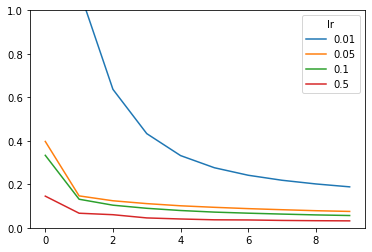

In [24]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

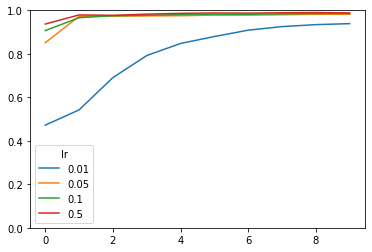

In [25]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [26]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
lr_calibrado = 0.5

# Calibración del Batch Size

In [27]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for batch in calibracion_batch:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()

  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=lr_calibrado),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" definimos el valor
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_batch, 'batch', array_descripciones)

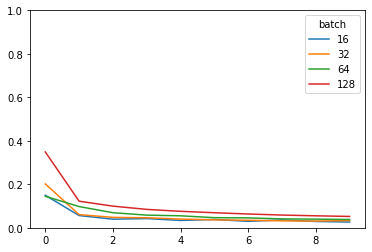

In [29]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

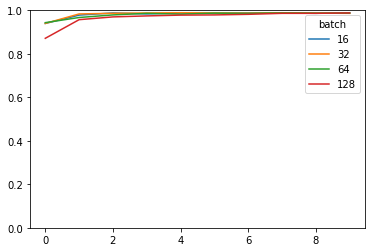

In [30]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [31]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
batch_calibrado = 32

# Calibración del optimizador

In [32]:
#Creamos un array en donde guardaremos las descripciones de cada entrenamiento
array_descripciones = []

#Iteramos cada calibración
for optimizador in calibracion_optimizador:
  #Obtenemos la red neuronal
  model = definicion_red_neuronal()
  
  #Agregamos el "lr" de la calibración
  #En "lr" ya hemos calibrado su valor, sabemos que el valor de 0.5 es el indicado
  model.compile(
    loss='binary_crossentropy',
    optimizer=eval(optimizador),
    metrics=['accuracy']
  )
  
  #Entrenamos la neurona
  #En "batch_size" colocamos 32, ya que fue lo que encontramos en la calibración anterior
  descripcion_de_entrenamiento = model.fit(x_train, y_train, epochs = numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado, verbose=0)

  #Convertimos la descripción del entrenamiento en un dataframe
  df = pd.DataFrame(
      descripcion_de_entrenamiento.history,
      index = descripcion_de_entrenamiento.epoch
  )

  #Agregamos el dataframe a la lista de descripciones de entrenamiento
  array_descripciones.append(df)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
#Obtenemos la evolucion del "loss" y el "accuracy"
dfLoss, dfAccuracy = obtener_df_loss_accuracy(calibracion_optimizador, 'optimizador', array_descripciones)

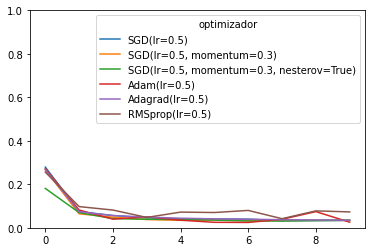

In [34]:
#Graficamos el dfLoss
dfLoss.plot(ylim=(0,1))

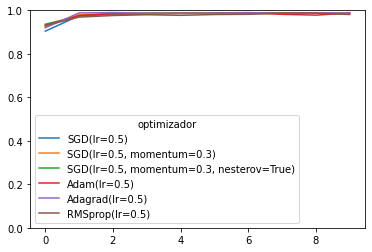

In [35]:
#Graficamos el dfLoss
dfAccuracy.plot(ylim=(0,1))

In [36]:
#NOS QUEDAMOS CON EL VALOR MÁS BAJO DEL LOSS O EL MÁS ALTO DEL ACCURACY
optimizador_calibrado = Adam(lr=0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Definicion del modelo

In [37]:
#Definimos el modelo con el inicializador calibrado
model = definicion_red_neuronal()

# Compilación del modelo

In [38]:
#Compilamos el modelo con el optimizador calibrado
model.compile(
  loss='binary_crossentropy',
  optimizer=optimizador_calibrado,
  metrics=['accuracy']
)

# Entrenamiento del modelo

In [39]:
#Entrenamos el modelo enviándole los features (x_train) y labels (y_train) de entrenamiento, con el batch calibrado
model.fit(x_train, y_train, epochs=numero_de_iteraciones_al_entrenar, batch_size=batch_calibrado)

Epoch 1/10
35/35 [==============================] - 0s 1ms/step - loss: 0.2294 - accuracy: 0.9152
Epoch 2/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0383 - accuracy: 0.9863
Epoch 3/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9772
Epoch 4/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9872
Epoch 5/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0236 - accuracy: 0.9881
Epoch 6/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0448 - accuracy: 0.9872
Epoch 7/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0354 - accuracy: 0.9863
Epoch 8/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9881
Epoch 9/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9809
Epoch 10/10
35/35 [==============================] - 0s 1ms/step - loss: 0.0473 - accuracy: 0.9854


# Accuracy de entrenamiento (patrones encontrados en la data)

In [40]:
#Con los features (x_train) que usamos para entrenar el modelo, realizamos las predicciones (y_train_prediccion)
y_train_prediccion = model.predict(x_train).ravel()
y_train_prediccion

array([1.0000000e+00, 2.1990498e-14, 8.9682106e-10, ..., 2.1727128e-05,
       1.0000000e+00, 1.6350057e-14], dtype=float32)

In [41]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_train_prediccion_binaria = y_train_prediccion > 0.5
y_train_prediccion_binaria

array([ True, False, False, ..., False,  True, False])

In [42]:
#Calculamos el error de entrenamiento
#INTERPRETACIÓN: El modelo encontró el 81.25% de los patrones existentes en la data
accuracy_score(y_train, y_train_prediccion_binaria)

0.9881494986326345

# Accuracy de uso (accuracy de predicción)

In [43]:
#Con los features (x_test) que no usamos para entrenar al modelo, realizamos las predicciones (y_test_prediccion)
y_test_prediccion = model.predict(x_test).ravel()
y_test_prediccion

array([9.99945045e-01, 1.96822905e-10, 1.00000000e+00, 1.00000000e+00,
       9.99997675e-01, 6.70245516e-14, 7.17724075e-11, 9.99695301e-01,
       1.00000000e+00, 2.17984844e-14, 8.60651076e-01, 9.46454790e-11,
       1.00000000e+00, 7.79219189e-10, 9.97345328e-01, 5.67541398e-18,
       1.00000000e+00, 1.82728748e-08, 2.28609936e-15, 9.99996543e-01,
       9.99944568e-01, 3.16545218e-19, 4.85827592e-17, 5.91479385e-18,
       9.99999166e-01, 1.00000000e+00, 1.86737667e-15, 5.54964874e-13,
       1.00000000e+00, 3.86505842e-01, 1.05098777e-11, 9.99998391e-01,
       9.61964536e-11, 1.00000000e+00, 1.24227302e-13, 2.08050117e-15,
       1.00000000e+00, 3.74016749e-14, 9.99997139e-01, 1.00000000e+00,
       1.06490062e-15, 2.84671283e-16, 1.00000000e+00, 1.08398984e-11,
       1.00000000e+00, 3.43297114e-13, 9.35759174e-13, 7.73918690e-12,
       2.08312448e-20, 2.82416222e-15, 2.45890974e-10, 1.36436835e-08,
       1.00000000e+00, 9.99993324e-01, 4.17909042e-19, 9.99993324e-01,
      

In [44]:
#Binarizamos las predicciones
#Todo lo que esté por encima de "0.5" será un "1"
#Todo lo que esté por debajo de "0.5" será un "0"
y_test_prediccion_binaria = y_test_prediccion > 0.5
y_test_prediccion_binaria

array([ True, False,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True, False,  True, False,  True, False,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
        True, False,  True,  True, False, False,  True, False,  True,
       False, False, False, False, False, False, False,  True,  True,
       False,  True, False,  True, False,  True,  True,  True, False,
       False, False, False,  True,  True, False,  True,  True, False,
       False, False, False,  True, False,  True,  True,  True,  True,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
        True,  True,

In [45]:
#Calculamos el error
#INTERPRETACIÓN: El modelo al ser usado en un entorno productivo, de 100 casos acertará en 80 y se equivocará en 20 casos
accuracy_score(y_test, y_test_prediccion_binaria)

0.9818181818181818

# Análisis final

In [46]:
#El modelo tiene un alto porcentaje de reconocimiento de patrones en los datos (98.26%)
#El modelo tiene un alto porcentaje de aciertos en nuestras predicciones (98.18%)
#La diferencia entre el porcentaje de reconocimiento de patrones (98.26%) y el porcentaje de aciertos (98.18%) es pequeña (0.08%)
#Como la diferencia es pequeña, estamos frente a un modelo que representa y predice muy bien la realidad de negocio
#Es un modelo que podemos usar en un entorno real de producción